In [1]:
!pip install -qqq fastf1

In [2]:
import fastf1 as ff1
import fastf1.plotting as ff1p
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [3]:
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

In [4]:
year = 2023
wknd = "Belgium"
ses = 'r'
drivers = ["VER", "LEC", "HAM"]
colors = list(map(lambda d: ff1p.driver_color(d), drivers))

In [5]:
session = ff1.get_session(year, wknd, ses)

weekend = session.event
session.load()

laps = dict((driver, session.laps.pick_driver(driver).pick_fastest()) for driver in drivers)

circuit_info = session.get_circuit_info()

lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: /root/.cache/fastf1.
	Size: 498.28 MB

DEFAULT CACHE ENABLED!
	Cache directory: /root/.cache/fastf1.
	Size: 498.28 MB
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.1.2]
INFO:fastf1.fastf1.core:Loading data for Belgian Grand Prix - Race [v3.1.2]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.r

In [6]:
delta = (laps[drivers[idx]].telemetry['Speed'] for idx in range(len(drivers)))
delta = list(map(lambda v: v.index(max(v)), zip(*delta)))

In [7]:
# Get an array of shape [n, 2] where n is the number of points and the second
# axis is x and y.
track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate and plot the track map.
rotated_track = rotate(track, angle=track_angle)

x, y = rotated_track[:, 0], rotated_track[:, 1]

In [8]:
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

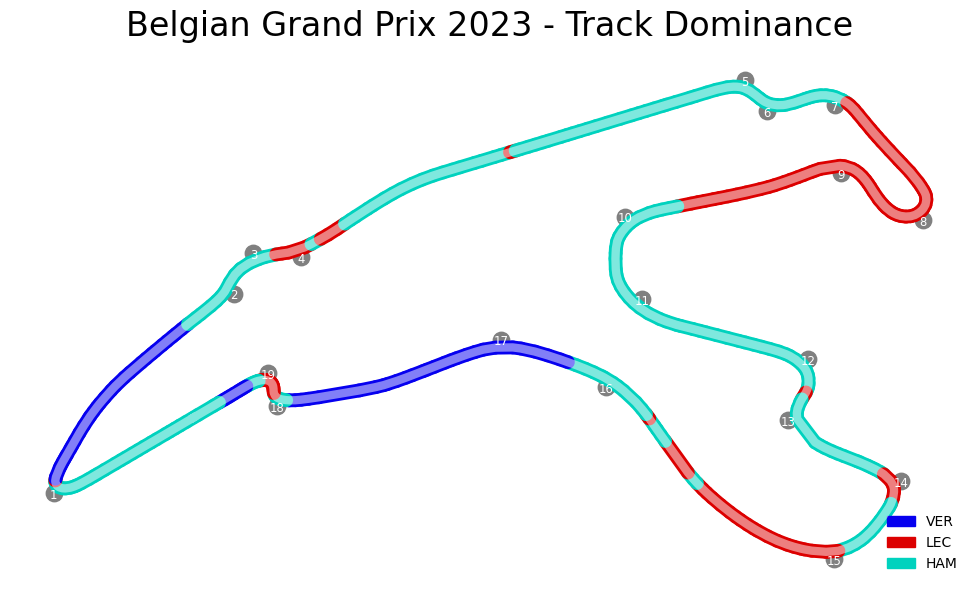

In [9]:
# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
fig.suptitle(f'{weekend.EventName} {year} - Track Dominance', size=24, y=0.97)

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')

# Create a continuous norm to map from data points to colors
cmap = ListedColormap(colors)

norm = plt.Normalize(min(delta), max(delta))
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=10)
lc.set_joinstyle("bevel")
lc.set_capstyle("round")

# Set the values used for colormapping
lc.set_array(delta)

# Merge all line segments together
line = ax.add_collection(lc)

# After this, we plot the data itself.
# Create background track line
ax.plot(x, y, color='white', linestyle='-', linewidth=6, zorder=100, alpha=0.5)


# Plot corners
offset_vector = [200, 0]

for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey', zorder=0, alpha=0.5)

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white', zorder=101)


# Legend
plt.legend(
    handles=[
        mpatches.Patch(color=colors[idx], label=f'{drivers[idx]}') for idx in range(len(drivers))
    ],
    loc="lower right",
    frameon=False
)

# Show the plot
plt.show()